
Cross-Validation Results:
                 Model  Max Features  Accuracy  F1 Score  Training Time (s)
0  Logistic Regression          5000  0.966618  0.919980               3.29
1          Naive Bayes          5000  0.973079  0.936437               0.51
2        Random Forest          5000  0.978282  0.950038              22.74
3  Logistic Regression         10000  0.964105  0.913143               0.65
4          Naive Bayes         10000  0.968233  0.923686               0.50
5        Random Forest         10000  0.974514  0.940367              20.14
6  Logistic Regression         20000  0.964105  0.913143               0.64
7          Naive Bayes         20000  0.968233  0.923686               0.53
8        Random Forest         20000  0.974514  0.940367              21.20

Best Configuration:
Model                Random Forest
Max Features                  5000
Accuracy                  0.978282
F1 Score                  0.950038
Training Time (s)            22.74
Name: 2, dtype: o

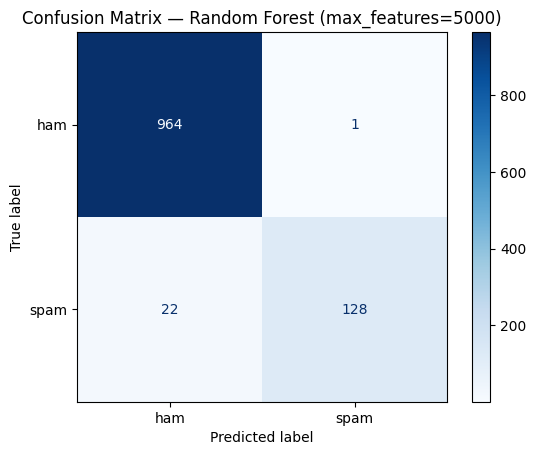

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


df = pd.read_csv('spam.csv', encoding='latin-1')[['v1','v2']]
df.columns = ['label', 'text']
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

X = df['text']
y = df['label']


max_features_list = [5000, 10000, 20000]
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42)
}


results = []
for max_features in max_features_list:
    for model_name, model in models.items():
        pipeline = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=max_features, stop_words='english')),
            ('clf', model)
        ])
        start = time.time()
        scores = cross_validate(
            pipeline, X, y, cv=5,
            scoring=['accuracy', 'f1_macro'],
            return_train_score=False, n_jobs=-1
        )
        elapsed = time.time() - start
        results.append({
            "Model": model_name,
            "Max Features": max_features,
            "Accuracy": np.mean(scores['test_accuracy']),
            "F1 Score": np.mean(scores['test_f1_macro']),
            "Training Time (s)": round(elapsed, 2)
        })

results_df = pd.DataFrame(results)
print("\nCross-Validation Results:")
print(results_df)


best_idx = results_df['F1 Score'].idxmax()
best_row = results_df.loc[best_idx]
print("\nBest Configuration:")
print(best_row)

best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=best_row['Max Features'], stop_words='english')),
    ('clf', models[best_row['Model']])
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
best_pipeline.fit(X_train, y_train)
y_pred = best_pipeline.predict(X_test)


cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham','spam'])
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix — {best_row['Model']} (max_features={best_row['Max Features']})")
plt.show()